In [ ]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from IPython.display import Image, display
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from graphviz import Digraph

warnings.filterwarnings('ignore')
%matplotlib inline


In [53]:
def adf_test(series):
    result = adfuller(series.dropna())
    return result[0], result[1]

In [54]:
def plot_series(series, col_name, suffix, output_dir, window=30):
    plt.figure(figsize=(8, 4))
    plt.plot(series, label=col_name, color='blue')
    if suffix == 'timeseries':
        plt.plot(series.rolling(window).mean(), label=f'{window}-day Rolling Mean', color='orange')
    plt.grid(True)
    plt.title(f'{col_name} {"with Rolling Mean" if suffix=="timeseries" else "Differenced"}')
    plt.xlabel('Date')
    plt.ylabel(col_name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{col_name}_{suffix}.png")
    plt.show()

In [55]:
def plot_acf_pacf(series, col_name, suffix, output_dir, lags=100):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series.dropna(), lags=lags, ax=ax[0])
    ax[0].set_title(f'ACF of {col_name} {"(Differenced)" if "diff" in suffix else ""}')
    plot_pacf(series.dropna(), lags=lags, ax=ax[1])
    ax[1].set_title(f'PACF of {col_name} {"(Differenced)" if "diff" in suffix else ""}')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{col_name}_{suffix}.png")
    plt.show()

In [56]:
def analyze_column(df, col, output_dir, window=30, lags=100):
    print(f"\n{'='*60}\nProcessing: {col}\n{'='*60}")
    series = df[col].dropna()

    plot_series(series, col, 'timeseries', output_dir, window)
    plot_acf_pacf(series, col, 'ACF_PACF', output_dir, lags)

    adf_stat, p_value = adf_test(series)
    print(f"ADF Statistic for {col}: {adf_stat:.4f}, p-value: {p_value:.4f}")

    if p_value > 0.05:
        print("--> Non-stationary, differencing applied.\n")
        diff_series = series.diff().dropna()
        plot_series(diff_series, col, 'first_difference', output_dir, window)
        plot_acf_pacf(diff_series, col, 'ACF_PACF_diff', output_dir, lags)
        adf_stat_diff, p_value_diff = adf_test(diff_series)
        print(f"ADF Statistic after differencing: {adf_stat_diff:.4f}, p-value: {p_value_diff:.4f}")
    else:
        print("--> Stationary, no differencing needed.\n")

In [57]:
def plot_correlation_heatmap(df, target_col, exogenous_cols, output_dir):
    corr = df[[target_col] + exogenous_cols].corr()
    plt.figure(figsize=(5, 3))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/correlation_heatmap.png")
    plt.show()

In [58]:
def plot_cross_correlation(df, target_col, exogenous_cols, output_dir, max_lag=365):
    lags = range(max_lag)
    plt.figure(figsize=(8, 5))
    for exog in exogenous_cols:
        cross_corr = [df[exog].shift(lag).corr(df[target_col]) for lag in lags]
        plt.plot(lags, cross_corr, label=f'{exog} vs {target_col}')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation')
    plt.title('Cross-Correlation with Lags')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/cross_correlation_lags.png")
    plt.show()

In [59]:
def check_granger_causality(df, target_col, exogenous_cols, output_dir, maxlag=30, alpha=0.05):
    dot = Digraph(comment='Granger Causality DAG')
    dot.node('WSE', target_col)
    results = {}

    for exog in exogenous_cols:
        dot.node(exog[0].upper(), exog)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            test_result = grangercausalitytests(df[[target_col, exog]].dropna(), maxlag=maxlag, verbose=False)

        causality_found = False
        for lag in range(1, maxlag + 1):
            p_val = test_result[lag][0]['ssr_ftest'][1]
            if p_val < alpha:
                print(f"{exog} Granger-causes {target_col} at lag {lag} (p={p_val:.4f})")
                dot.edge(exog[0].upper(), 'WSE', label=f'p={p_val:.4f}, lag={lag}')
                results[exog] = (lag, p_val)
                causality_found = True
                break
        if not causality_found:
            print(f"{exog} does NOT Granger-cause {target_col} (all p >= {alpha})")

    dot.render(f"{output_dir}/granger_causality_dag", format='png', cleanup=True)
    display(Image(filename=f"{output_dir}/granger_causality_dag.png"))
    return results

In [60]:
def feature_importance_rf(df, target_col, exogenous_cols):
    df_ml = df[[target_col] + exogenous_cols].dropna()
    X = df_ml[exogenous_cols]
    y = df_ml[target_col]
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    for feature, importance in zip(X.columns, importances):
        print(f"{feature} feature importance: {importance:.4f}")

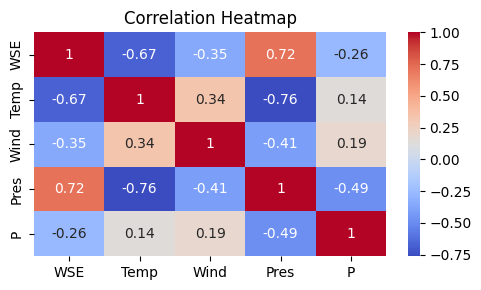

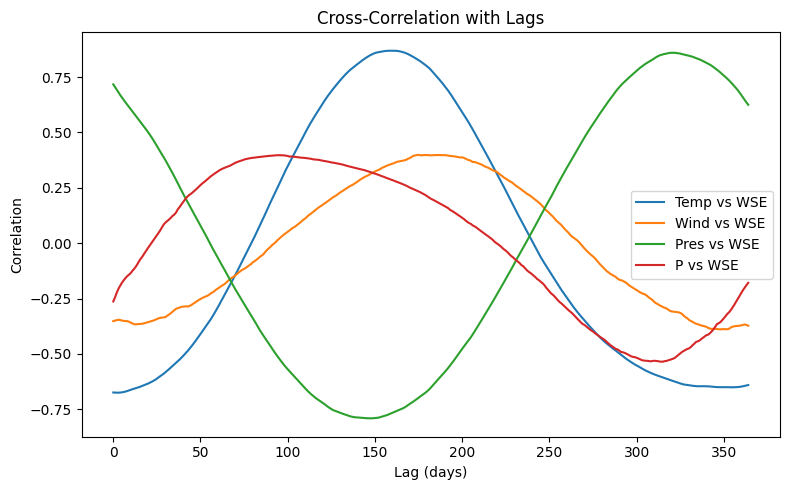


Processing: WSE


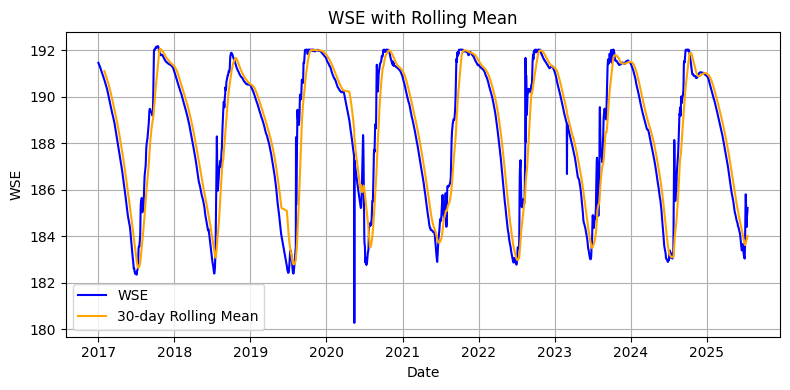

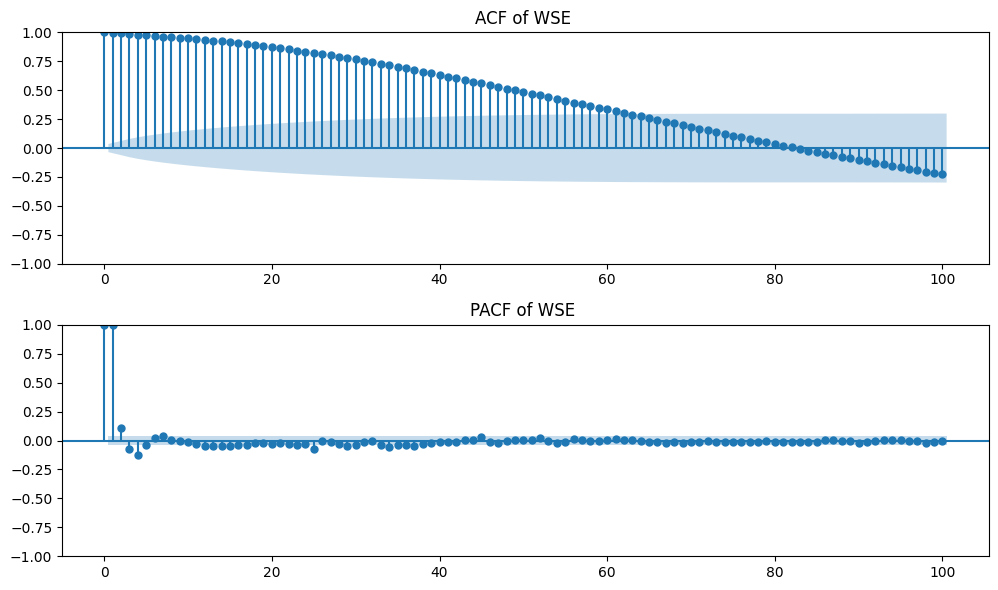

ADF Statistic for WSE: -5.5328, p-value: 0.0000
--> Stationary, no differencing needed.


Processing: Temp


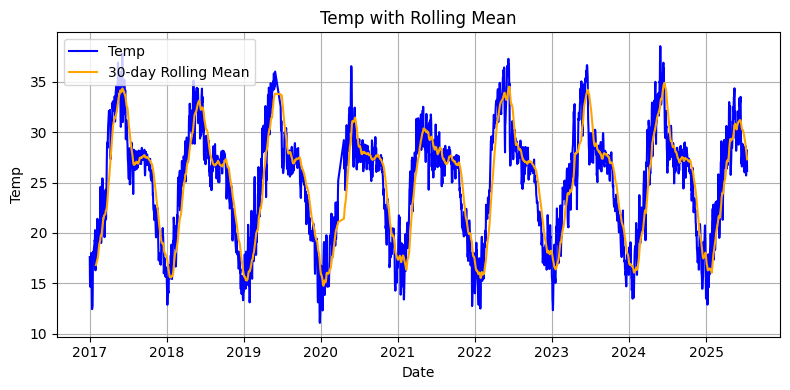

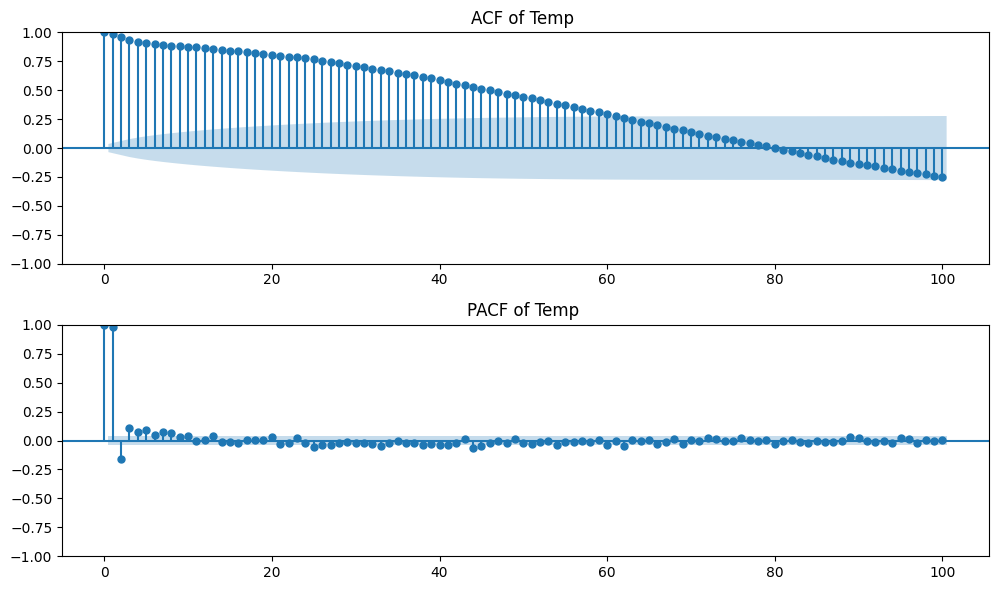

ADF Statistic for Temp: -4.0437, p-value: 0.0012
--> Stationary, no differencing needed.


Processing: Wind


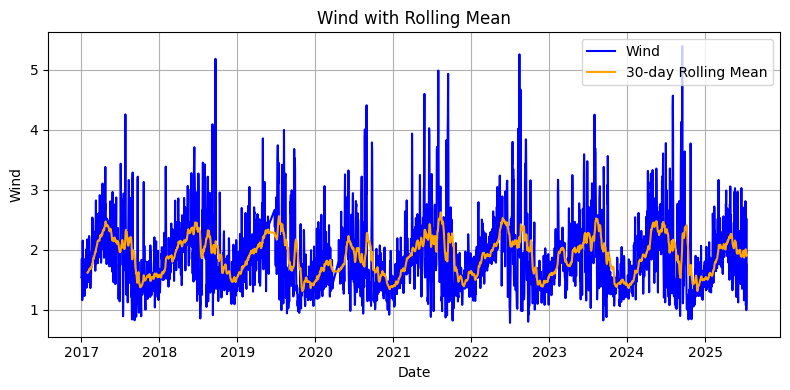

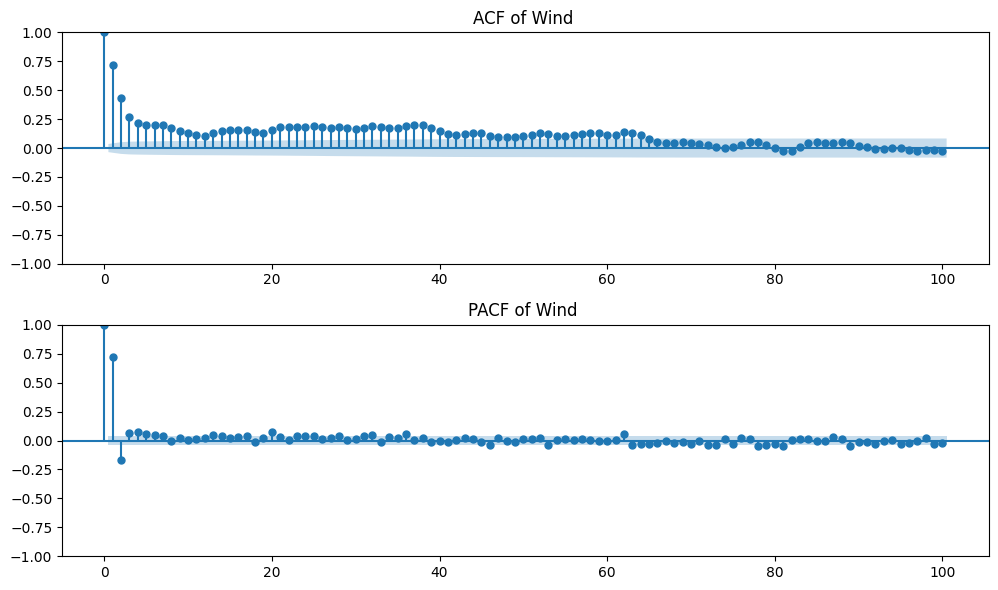

ADF Statistic for Wind: -6.3822, p-value: 0.0000
--> Stationary, no differencing needed.


Processing: Pres


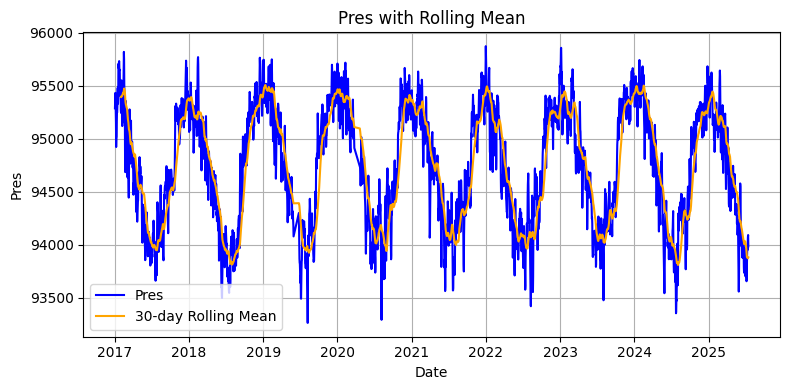

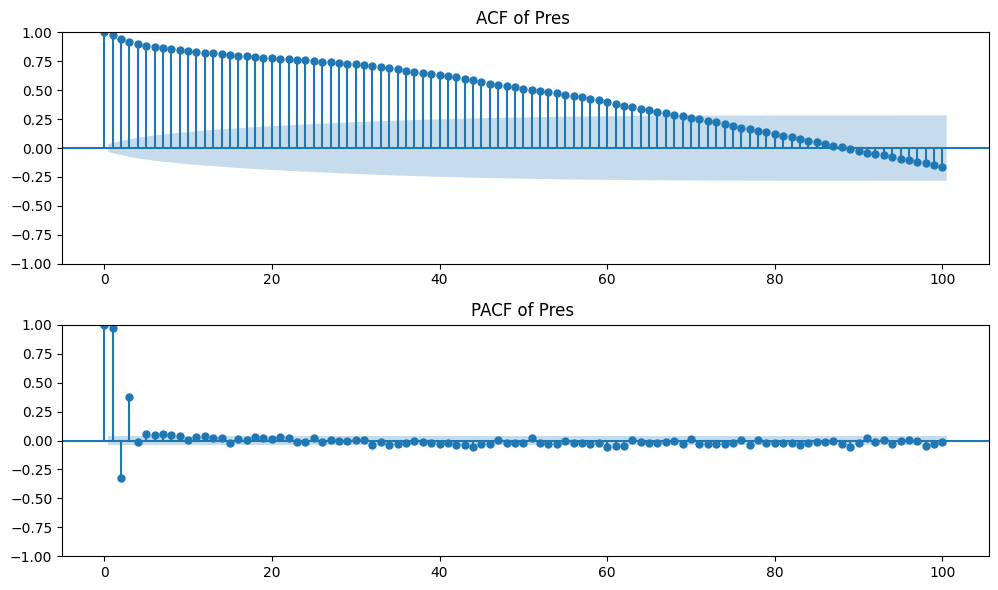

ADF Statistic for Pres: -3.6724, p-value: 0.0045
--> Stationary, no differencing needed.


Processing: P


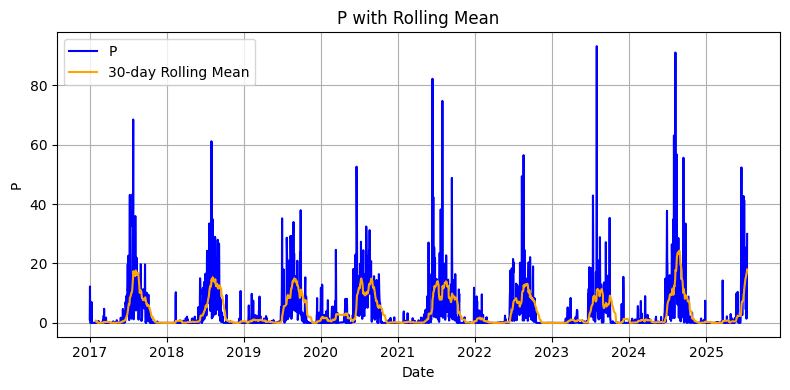

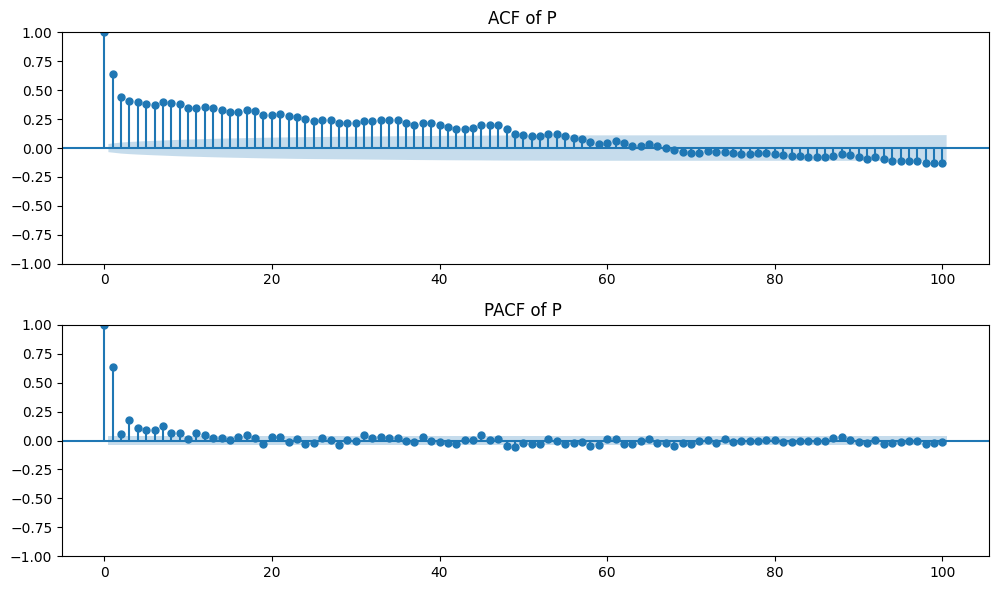

ADF Statistic for P: -5.2416, p-value: 0.0000
--> Stationary, no differencing needed.

Temp Granger-causes WSE at lag 1 (p=0.0055)
Wind Granger-causes WSE at lag 10 (p=0.0078)
Pres Granger-causes WSE at lag 1 (p=0.0000)
P Granger-causes WSE at lag 1 (p=0.0000)


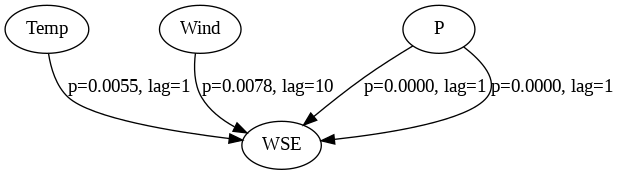

Temp feature importance: 0.3348
Wind feature importance: 0.0929
Pres feature importance: 0.5022
P feature importance: 0.0701


In [61]:
# Parameters
csv_path = r"/content/Rihand_weather.csv"
output_dir = r"/content/output_plots"
window = 30
lags = 100

os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv(csv_path)

date_col = 'Date' if 'Date' in df.columns else df.columns[0]
df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col)

target_col = 'WSE'
exogenous_cols = ['Temp', 'Wind', 'Pres', 'P']

# Correlation
plot_correlation_heatmap(df, target_col, exogenous_cols, output_dir)

# Cross-correlation
plot_cross_correlation(df, target_col, exogenous_cols, output_dir)

# Per-column EDA
for col in [target_col] + exogenous_cols:
    analyze_column(df, col, output_dir, window, lags)

# Granger causality DAG
check_granger_causality(df, target_col, exogenous_cols, output_dir)

# Random Forest importance
feature_importance_rf(df, target_col, exogenous_cols)
